# <b>BOT-HUMAN CLASSIFIER</b>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
import matplotlib.pyplot as plt
import os
import json
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Human Session Generation Function

### Explanation:

Path behavior:
(x, y) is updated with small, noisy steps.
Uses np.random.normal(2, 1) to simulate natural hand jitter and uneven motion.

Timing:
Time between events is not fixed; it's drawn from a normal distribution around 50ms with some noise.

Result:
The path looks curvy, irregular, human-like.
Velocity and direction change gradually and unpredictably.

In [2]:
# ==== 1. SESSION GENERATION ====

def generate_human_session():
    num_points = np.random.randint(20, 100)
    x, y, t = 0, 0, 0
    session = []
    for _ in range(num_points):
        x += np.random.normal(2, 1)
        y += np.random.normal(2, 1)
        t += np.abs(np.random.normal(50, 20))
        session.append((x, y, t))
    metadata = np.random.choice(['morning', 'afternoon', 'evening'])
    return session, metadata


## Bot Session Generation Function

### Explanation:

Path behavior:
Draws a straight line from a start to end coordinate.
Movement is perfectly linear — (x, y) increases in equal steps.

Timing:
Every point is exactly 50ms apart — no variation.

Result:
The path is too clean, too smooth, and too regular — a signature of bots or automation scripts.

In [3]:
def generate_bot_session():
    num_points = np.random.randint(20, 100)
    start_x, start_y = 0, 0
    end_x, end_y = np.random.randint(100, 500), np.random.randint(100, 500)
    t = 0
    session = []
    for i in range(num_points):
        x = start_x + (end_x - start_x) * (i / num_points)
        y = start_y + (end_y - start_y) * (i / num_points)
        t += 50  # constant interval
        session.append((x, y, t))
    metadata = np.random.choice(['morning', 'afternoon', 'evening'])
    return session, metadata

## Generating 50 human and 50 bot sessions, marked as 1 and 0 respectively.

In [4]:
def generate_sessions(n_human=50, n_bot=50):
    data = []
    for _ in range(n_human):
        session, meta = generate_human_session()
        data.append((session, meta, 1))  # 1 = human
    for _ in range(n_bot):
        session, meta = generate_bot_session()
        data.append((session, meta, 0))  # 0 = bot
    return data

## Feature Engineering

For each session, we extract:
1. `velocity_mean`: Average velocity across pointer events.
2. `velocity_std`: Standard deviation of velocity — captures motion jitter.
3. `inter_event_time_std`: Variability in time between pointer movements.
4. `direction_entropy`: How random the movement directions are (higher for humans).
5. `total_path_length`: Total distance covered by the pointer.

In [5]:
# ==== 2. FEATURE EXTRACTION ====

def extract_features(session_data):
    features = []
    labels = []
    for session, meta, label in session_data:
        xs, ys, ts = zip(*session)
        xs, ys, ts = np.array(xs), np.array(ys), np.array(ts)

        dx = np.diff(xs)
        dy = np.diff(ys)
        dt = np.diff(ts) + 1e-3

        velocities = np.sqrt(dx**2 + dy**2) / dt
        directions = np.arctan2(dy, dx)

        # Bin directions and compute entropy
        hist, _ = np.histogram(directions, bins=10)
        hist_sum = np.sum(hist)
        if hist_sum == 0:
            dir_entropy = 0.0
        else:
            hist = hist / hist_sum
            dir_entropy = entropy(hist + 1e-6)

        features.append([
            np.mean(velocities),
            np.std(velocities),
            np.std(dt),
            dir_entropy,
            np.sum(np.sqrt(dx**2 + dy**2))
        ])
        labels.append(label)

    return np.array(features), np.array(labels)


## Training & Evaluation using Random Forest Model

In [6]:
# ==== 3. TRAINING & EVALUATION ====

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    #print(json.dumps(report, indent=2))
    #print("ROC AUC:", auc)

    print("\nClassification Report:")
    headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
    table = []
    for label in ["0", "1"]:
        row = report[label]
        table.append([label, f"{row['precision']:.2f}", f"{row['recall']:.2f}", f"{row['f1-score']:.2f}", int(row['support'])])
    print(tabulate(table, headers=headers, tablefmt="github"))

    if not os.path.exists("results"):
        os.makedirs("results")

    with open("results/metrics.json", "w") as f:
        json.dump({"roc_auc": auc, "classification_report": report}, f, indent=2)

    # Confusion matrix
    print("\n\nConfusion Matrix of Test Set: ")
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))  # Explicitly create a figure
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bot", "Human"])
    disp.plot(cmap="Blues", values_format="d", ax=ax)
    ax.set_title("Confusion Matrix")
    plt.savefig("results/confusion_matrix.png")
    plt.show()
    plt.close()
    
    # Plot ROC AUC
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title("ROC Curve")
    plt.savefig("results/roc_curve.png")
    

🧍 Human Sessions (2 examples):

Human #1:
  Metadata: afternoon
  First 5 Pointer Events: [(2.098985285629161, 2.0605686635350233, 32.2024831854649), (3.812852163251265, 5.048790993815471, 88.85637193982805)] 

Human #2:
  Metadata: afternoon
  First 5 Pointer Events: [(0.8146405028465693, 2.379849994434747, 59.20137893494071), (3.4001301983834944, 2.3692396385333194, 109.85427598192568)] 

🤖 Bot Sessions (2 examples):

Bot #1:
  Metadata: afternoon
  First 5 Pointer Events: [(0.0, 0.0, 50), (5.789473684210526, 5.5438596491228065, 100)] 

Bot #2:
  Metadata: morning
  First 5 Pointer Events: [(0.0, 0.0, 50), (2.125, 3.703125, 100)] 


Classification Report:
|   Class |   Precision |   Recall |   F1-Score |   Support |
|---------|-------------|----------|------------|-----------|
|       0 |           1 |        1 |          1 |         8 |
|       1 |           1 |        1 |          1 |        12 |


Confusion Matrix of Test Set: 


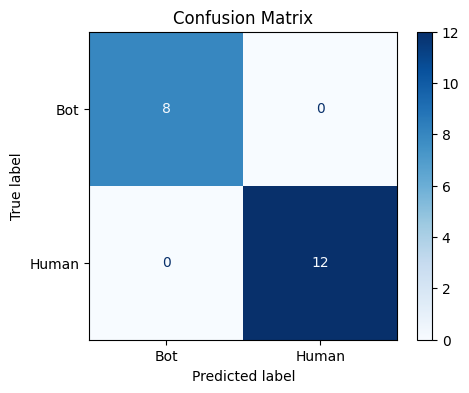

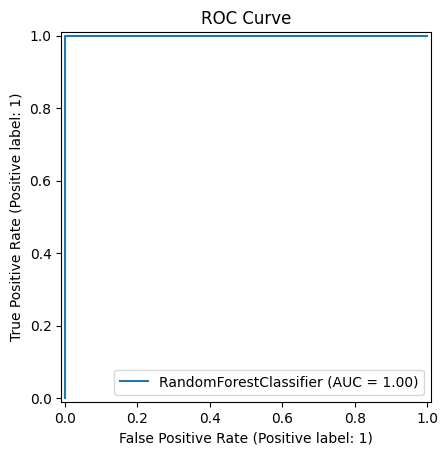

In [7]:
# ==== 4. MAIN EXECUTION ====

def main():
    sessions = generate_sessions()
    # Separate human and bot sessions
    human_sessions = [s for s in sessions if s[2] == 1]
    bot_sessions = [s for s in sessions if s[2] == 0]
    
    # Print 5 from each
    print("🧍 Human Sessions (2 examples):\n")
    for i, (session, meta, label) in enumerate(human_sessions[:2]):
        print(f"Human #{i+1}:")
        print("  Metadata:", meta)
        print("  First 5 Pointer Events:", session[:2], "\n")
    
    print("🤖 Bot Sessions (2 examples):\n")
    for i, (session, meta, label) in enumerate(bot_sessions[:2]):
        print(f"Bot #{i+1}:")
        print("  Metadata:", meta)
        print("  First 5 Pointer Events:", session[:2], "\n")
        
    X, y = extract_features(sessions)
    train_model(X, y)

if __name__ == "__main__":
    main()